In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.nn as nn
import torch

from sklearn.utils.class_weight import compute_class_weight
import networkx as nx

from config import Settings, get_config, get_default_config
from models.gcn_model import *

from data.data_generator import tsp_instance_reader

from utils.tsplib2 import ReaderTSP, PlotterTSP
from utils.tsplib2_graph import GraphBuilder
from utils.tsplib_utils import test_one_tsp, multiprocess_write, load_prob_matrix

In [3]:
#path_tsplib = r'../../ML-Constructive/version1/data/test/TSPLIB/'
path_tsplib = r'./data/TSPLib/instances'
path_tsplib_opt = r'./data/TSPLib/optimal'
files = [f for f in os.listdir(path=path_tsplib) if f.endswith('.tsp')]

problem_set = []
for item in files:
    problem = {'name': item, 'size': int(re.findall('[0-9]+', item)[0])}
    problem_set.append(problem)

#order problem set by size, ranging from 100 to 1748
problem_set.sort(key=lambda x: x['size'], reverse=False)

df_ps = pd.DataFrame.from_dict(problem_set)

### 1. Read a TSP instance

In [4]:
tsp_inst_name = 'ch130' #'gr137' #'kroA100' #'pr107' #'rd100.tsp'
full_tsp_inst = os.path.join(path_tsplib, tsp_inst_name + '.tsp')

tspReader = ReaderTSP()
n_points, coord_buff, distance_matrix, inst_name, optimal_tour = tspReader.read_instance(full_tsp_inst)


#### 1.1 Rescale instance

In [5]:
x_y_min = np.min(coord_buff, axis=0)
scale = 1.0 / np.max(np.max(coord_buff, axis=0)-x_y_min)
node_coord = coord_buff - x_y_min
node_coord *= scale
distance_matrix *= scale

In [6]:
plotter = PlotterTSP(None)
G = GraphBuilder(pos=coord_buff, dist_matrix=distance_matrix)

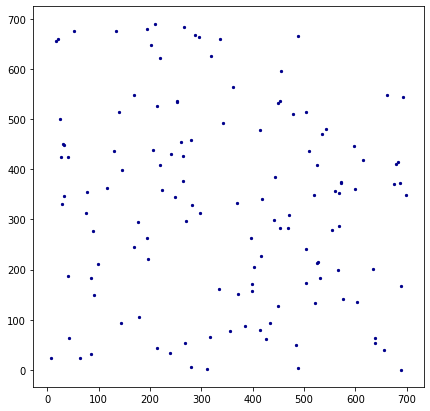

In [7]:
plt.figure(figsize=(7,7))
plotter.plot_points(coord_buff)
plt.show()

### 2. Graph Sampling

In [8]:
K = 19; K_expand = K

tsp_source = (coord_buff, optimal_tour)
edge, edges_value, node, node_coord, edge_target, node_target, mesh, omega, opt = \
    test_one_tsp(tsp_source=tsp_source, \
    coor_buff=coord_buff, node_num=n_points,  cluster_center=0, top_k=K, top_k_expand=K_expand)

### 2.1 Plotting one instance

<Figure size 1440x1440 with 0 Axes>

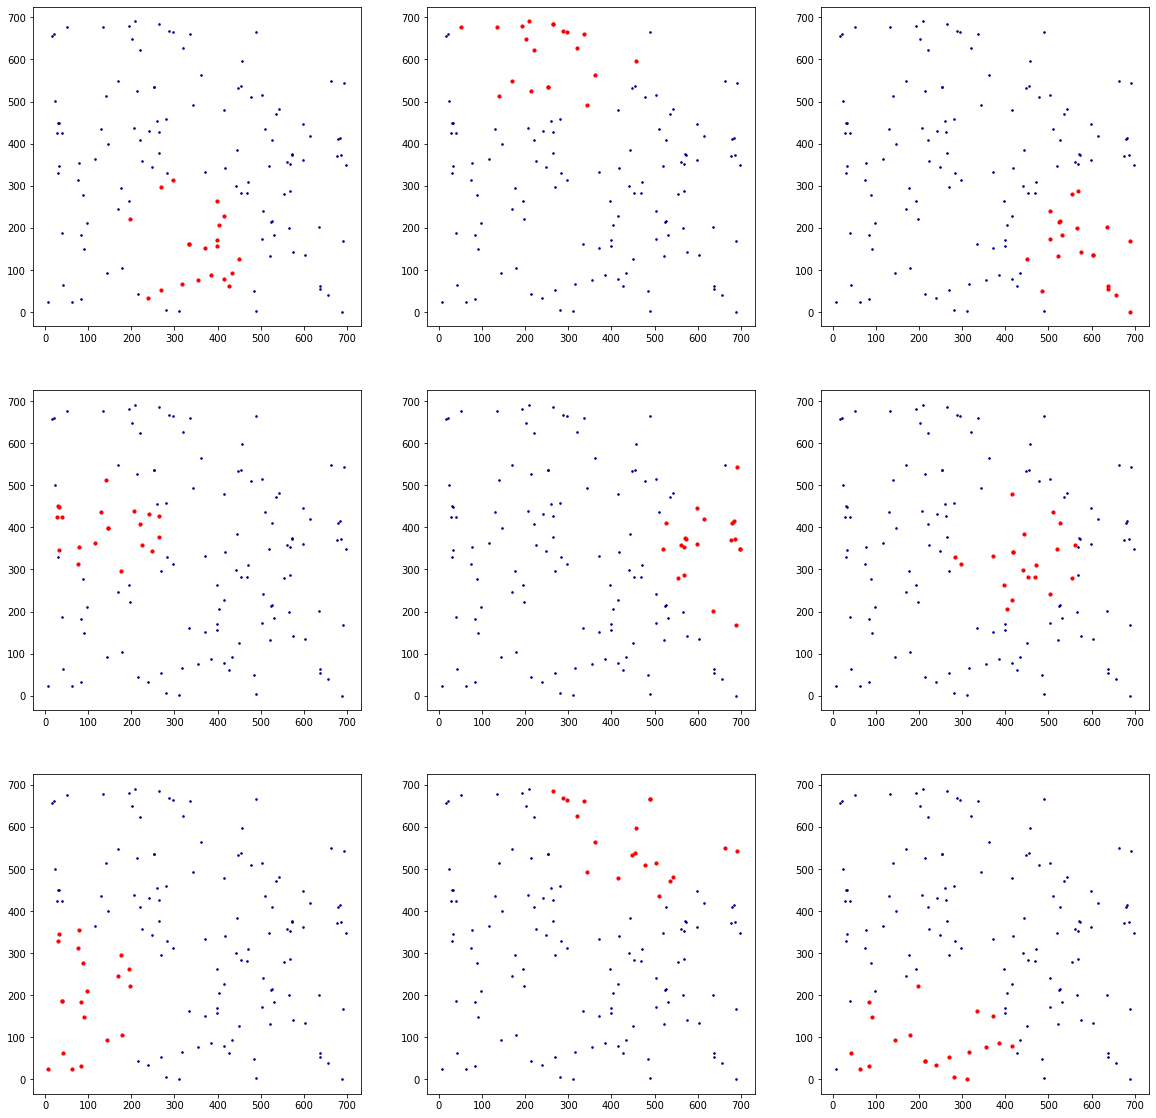

In [9]:
plt.figure(figsize=(20,20))

plt_dim = 3
fig, axs = plt.subplots(plt_dim, plt_dim)
fig.set_size_inches((20,20))

pos = coord_buff
for i in range( plt_dim ** 2):        
    axs[i // plt_dim, i % plt_dim].scatter(pos[:, 0], pos[:, 1], 10, color='darkblue', marker='.')

    samples = mesh[i][0][0]
    axs[i // plt_dim, i % plt_dim].scatter(pos[samples, 0], pos[samples, 1], 10, color='red', marker='o')
plt.show()

### 3. Loading trained Att-GCN based on TSP20-trainset

In [10]:
# model-parameter
config_path = "configs/tsp20.json"
config = get_config(config_path)

# setting random seed to 1
if torch.cuda.is_available():
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed_all(1)
else:
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

In [11]:
# Instantiate the network
net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
if torch.cuda.is_available():
    net.cuda()  
# Define optimizer
learning_rate = config.learning_rate
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# Load checkpoint
log_dir = f"./logs/{config.expt_name}/"
if torch.cuda.is_available():
    # TSP-20
    checkpoint = torch.load("logs/tsp20/best_val_checkpoint.tar")
else:
    checkpoint = torch.load("logs/tsp20/best_val_checkpoint.tar", map_location='cpu')
# Load network state
net.load_state_dict(checkpoint['model_state_dict'])
# Load optimizer state
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Load other training parameters
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
for param_group in optimizer.param_groups:
    learning_rate = param_group['lr']

#### 3.1 Heatmap generator on TSP20

In [12]:
threshold = len(edge)
batch_size = 1

config.expt_name = 'tsp{}'.format(inst_name)
num_nodes = n_points


In [13]:
# init
count_buff = np.zeros(shape=(batch_size*threshold, ), dtype=np.int32)
edges = np.zeros(shape=(batch_size*threshold, K+1, K+1), dtype=np.int32)
edges_values = np.zeros(shape=(batch_size*threshold, K+1, K+1), dtype=np.float16)
nodes = np.zeros(shape = (batch_size*threshold, K+1), dtype=np.int32)
nodes_coord = np.zeros(shape = (batch_size*threshold, K+1, 2), dtype=np.float16)
edges_target = np.zeros(shape = (batch_size*threshold, K+1, K+1), dtype=np.int32)
nodes_target = np.zeros(shape = (batch_size*threshold, K+1), dtype=np.int32)
meshs = np.zeros(shape = (batch_size*threshold, 2, K+1, K+1), dtype=np.int32)

Omegas = np.zeros(shape = (batch_size, num_nodes, num_nodes), dtype=np.int32)
opts = np.zeros(shape = (batch_size, num_nodes+1), dtype=np.int32)

In [14]:
sum_time = 0

for i in range(batch_size):
        tsp_source = (coord_buff, optimal_tour)
        edge, edges_value, node, node_coord, edge_target, node_target, mesh, omega, opt = \
                test_one_tsp(tsp_source=tsp_source, \
                        coor_buff=coord_buff, node_num=n_points,  cluster_center=0, top_k=K, top_k_expand=K_expand)
        edges[i*threshold:(i+1)*threshold, ...] = edge
        edges_values[i*threshold:(i+1)*threshold, ...] = edges_value
        nodes[i*threshold:(i+1)*threshold, ...] = node
        nodes_coord[i*threshold:(i+1)*threshold, ...] = node_coord
        edges_target[i*threshold:(i+1)*threshold, ...] = edge_target
        nodes_target[i*threshold:(i+1)*threshold, ...] = node_target
        meshs[i*threshold:(i+1)*threshold, ...] = mesh



In [15]:
with torch.no_grad():
        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(nodes_target).type(dtypeLong), requires_grad=False)

        # Compute class weights
        edge_labels = y_edges.cpu().numpy().flatten()
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        y_preds_prob = F.softmax(y_preds, dim=3)
        y_preds_prob_numpy = y_preds_prob.cpu().numpy()

In [16]:
avg_mean_rank = []
for i in range(batch_size):
    heatmap_path = f'./results/heatmap/tsp_tsplib/heatmaptsp_{inst_name}_{i}.txt'
    rank = multiprocess_write(y_preds_prob_numpy[i*threshold:(i+1)*threshold, ...],
                                                        meshs[i*threshold:(i+1)*threshold, ...], Omegas[i, ...],
                                                        num_nodes, heatmap_path, True, opts[i, ...])
    avg_mean_rank.append(rank)

33 (33, 20, 20, 2)


In [18]:
prob_mtx = load_prob_matrix(f'./results/heatmap/tsp_tsplib/heatmaptsp_{inst_name}_{i}.txt')

#### 3.2 Find the top K Candidate List based on probability

In [19]:
topK_CL = (-prob_mtx).argsort(axis=1)[:,:K+1]

max_prob = prob_mtx.max()
topK_CL_values = prob_mtx[ np.array([[i] * (K+1) for i in range(num_nodes)]).flatten(), topK_CL.flatten()].reshape(num_nodes, K + 1)
topK_CL_intensity = np.round(topK_CL_values * 10 / max_prob).astype(int)




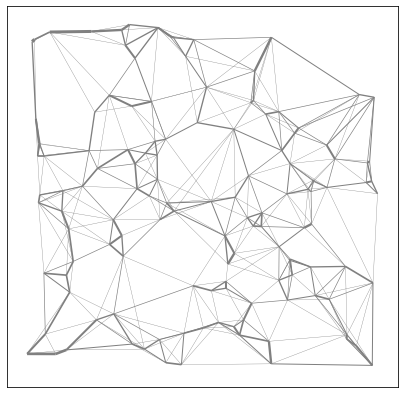

In [20]:
plt.figure(figsize=(7,7))
G_edges = G.G.copy()
GraphBuilder.draw_edges(G_edges, coord_buff, topK_CL, topK_CL_intensity)

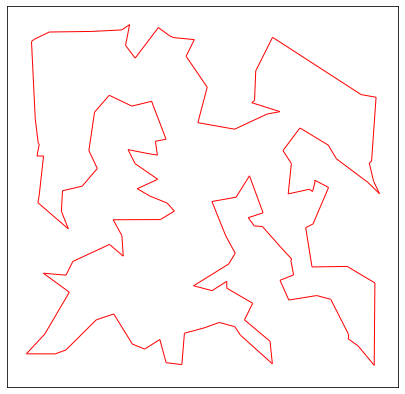

In [21]:
plt.figure(figsize=(7,7))
G_opt = G.G.copy()
opt_edges = GraphBuilder.add_optimal_edges(G_opt, optimal_tour)
for edge in G_opt.edges():
    nx.draw_networkx_edges(G_opt, coord_buff, edgelist=[edge], edge_color='red')

In [85]:
#df_ps
G